<a href="https://colab.research.google.com/github/JoaoSiqueiraDS/Joao_Siqueira_Portifolio/blob/master/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

If it has never happened to you, you probably know someone who has his/her credit card cloned. Fraudulent transactions represent billions of dollars of loss for banks and regular citizens. Tackling online fraud is no trivial and machine learning is a suitable solution to do so. The goal of this project is to train two models to forecast fraudulent transactions. A [data set from Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) was used in this analysis. The data set features 290 thousands of transactions, from which 492 are fraudulent. Another characteristic of this data set is that it is all the features (columns) are numeric due to safety and privacy. The columns are then named as V1, V2, V3, etc. The only features with their actual names in this data set are "Time", "Amount" and "Class". This last one is related to the whether the transaction is regular or fraudulent. This project is is divided into 5 parts: exploratory data analysis, data preparation, machine learning model, assessing the model performance and predicting the with test data. Well, lets get started.

<p align=center>
<img src="https://i.ibb.co/9mPwvKZ/1936a278707545.png" width="60%"></p>

Some information of this data set:

1 - It contains transactions made by credit cards in September 2013 by European cardholders.

2 - It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

3 - Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.

4 - Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.

5 - Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Exploratory data analysis

The very first thing to be done in a machine learning project is to understand better the data set. Questions such as "Are there outliers?", "Is there null values?" or "How balanced is the data set" needs to be answered before moving forward.

<p align=center>
<img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1051&q=80" width="50%"></p>

The very first thing to do is certainly importing the necessary libraries. By the way, this project uses Python only.

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configure Seaborn

sns.set_style('dark')

!pip install -q scikit-plot

import scikitplot as skplt

Then the data set is related to a variable *df* . Yet in this part a test data frame is created using the .sample() method. This data frame is going to be used as an ultimate validation of the trained model.


In [2]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# Importing the data set to dataframe (df)

df = pd.read_csv(file_path)

# Creating a test dataset

test = df.sample(frac=0.15, random_state=0)

Nice … Now with our data frame df defined it is possible to analyze the data. Through the method df.head()   it was possible to take very first look at the data and the method df.describe() could give us some statistical information. For example, through this last analysis it was possible to detect outliers in the "Amount" variable. Another important analysis done was counting the number of null values on each column. That was possible through a simple command df.isnull().sum(). There are no missing values. 
Checking how balanced is the data set is the next step. Seaborn is a good option for this kind of analysis.



In [ ]:
# First lines of the data set

df.head()

In [ ]:
# Stats summary

df.describe()

In [ ]:
# Is there null values?

df.isnull().sum().max()

In [ ]:
# plotting classes

fig, ax = plt.subplots()

sns.countplot("Class", data=df, ax=ax, hue="Class", palette='RdBu')
ax.set_title("Class distribution")
plt.plot()
plt.tight_layout()

In [ ]:
from IPython.core.pylabtools import figsize
# Plotting Class according to Time

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins=40

ax[0].hist(df['Time'][df['Class']==0], bins=num_bins, color='b')
ax[1].hist(df['Time'][df["Class"]==1], bins=num_bins, color='r')

ax[0].set_title('Regular')
ax[1].set_title('Fraud')

plt.xlabel('Time-s')
plt.ylabel('Transaction')
plt.tight_layout()

In [ ]:
# Plotting the "Amount" variable for frauds and regular transactions

fig, ax = plt.subplots(figsize=(6,12), sharex=True)

sns.boxplot(df['Class'], df['Amount'], showmeans=True, ax=ax)
plt.ylim((-20,400))
plt.xticks([0,1],['Normal','Fraud'])
plt.tight_layout()

In [ ]:
# Fraud stats

df.loc[(df['Class']==1) & (df["Amount"]<2000), ["Amount"]].describe()

In [ ]:
# Density Plots

density_df = df.drop(["Class", 'Amount', 'Time'], axis=1)
num_plots = len(density_df)

df_class_0 = df[df['Class']==0]
df_class_1 = df[df['Class']==1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)
idx = 0

for col in density_df:
  idx += 1
  plt.subplot(7, 4, idx, facecolor='#8b9d87')
  sns.kdeplot(df_class_0[col], label="Class 0", shade=True, color="r")
  sns.kdeplot(df_class_1[col], label="Class 1", shade=True, color='k')
  plt.title(col, fontsize=10)
plt.tight_layout()

## Data Preparation

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). In this dataset the variables "Time" and "Amount" were standardized, as seen below. For this step it was used the library Scikit-Learn.

In [12]:
# Having Time and Amount in the same scale

df_clean = df.copy()

std_scaler = StandardScaler()
df_clean["std_amount"]=std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1,1))
df_clean['std_time']=std_scaler.fit_transform(df_clean['Time'].values.reshape(-1,1))
df_clean.drop(['Time','Amount'], axis=1, inplace=True)

The next step is to separate the data set in train and validation. Again Scikit-Learn was used.

In [13]:
# Separate the data set in train and validation

X = df_clean.drop("Class", axis=1)
y = df['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True)


Previously it was seen that this data set is absolutely unbalanced. To solve this problem a method of under-sampling, which randomly extracts a sub class from the main class, was applied to the data set.

In [14]:
# Balancing the data. In this project it will be done by suing the library IMBLearn and UnderSampling

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [15]:
# Checking how balanced the data is

print(pd.Series(y_rus).value_counts())

0    369
1    369
Name: Class, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


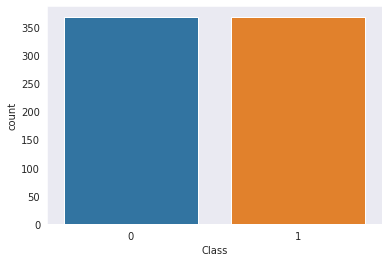

In [16]:
# Plotting the new distribution

sns.countplot(y_rus)

Correlation Matrix can show unexpected relations in our data set. There is a huge difference between a correlation matrix of a balanced and unbalanced data set. That reinforces the necessity of balancing the data set.

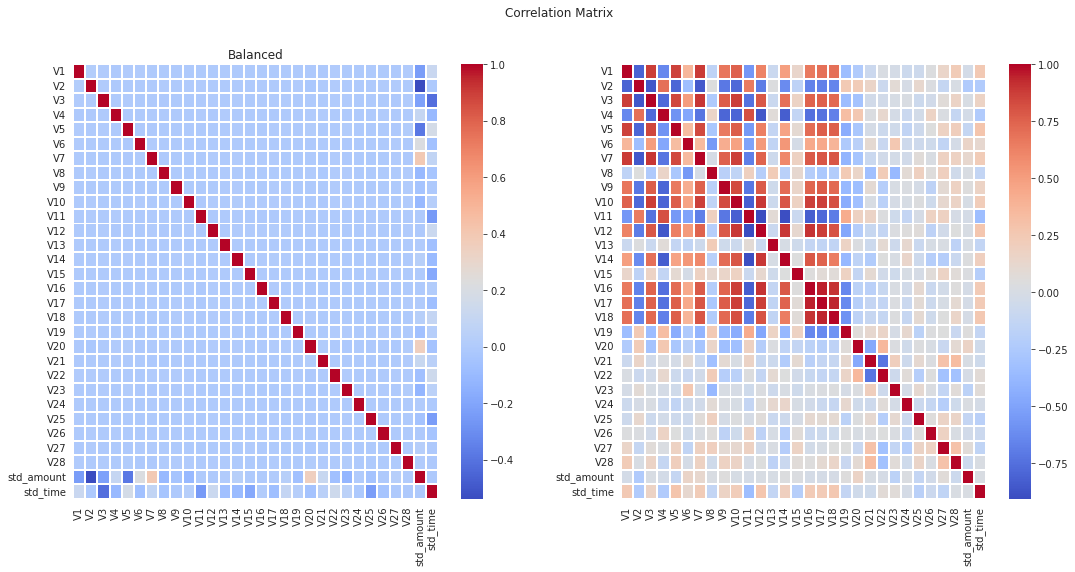

In [17]:
# Plotting a correlation matrix

corr = X_train.corr()

corr_rus = pd.DataFrame(X_rus).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
fig.suptitle('Correlation Matrix')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=1, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Unbalanced')

sns.heatmap(corr_rus, xticklabels=corr_rus.columns, yticklabels=corr_rus.columns, linewidths=1, cmap='coolwarm', ax=ax[1])
ax[0].set_title('Balanced')

plt.show()

## Learning Model

Now the data is prepared to train a model. The objective of this project is to train a model to forecast credit card frauds. This way, for this the model chosen was Logistic Regression, which is applied to predict categorical variables (yes or no, tru or false, malign or benign, cat or dog, etc).

The steps for training a model and predict, after choosing it, are:
1. Instantiating the model
2. Train the model
3. Predict using the model

In [18]:
# Instantiating the model 

np.random.seed(2)

model=LogisticRegression()
model.fit(X_rus, y_rus)

# Predicting using Model 

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

LogisticRegression()

In [20]:
# Predicting using Model 

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

## Assessing the machine model performance.

Great! We have now a machine learning model that can tell us, based on some bank information, whether a transaction is more likely or not to be a fraud. But, is the model predicting well? Let's answer it through a confusion matrix, classification report, accuracy and area-under-curve score.

classification report: 
               precision    recall  f1-score   support

           0     0.9999    0.9592    0.9791     71079
           1     0.0388    0.9512    0.0745       123

    accuracy                         0.9592     71202
   macro avg     0.5193    0.9552    0.5268     71202
weighted avg     0.9983    0.9592    0.9776     71202

Accuracy: 0.9591584506053201
AUC:0.9551958504432889


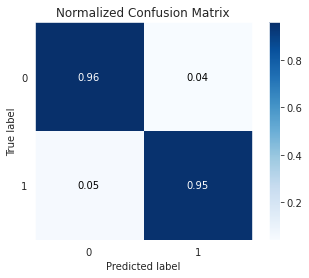

In [22]:
# Plotting Logistic Regression model

# Plotting the confusion matrix

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)

# Print classification report

print("classification report: \n", classification_report(y_val, y_pred, digits=4))

# Print model accuracy

print("Accuracy: {}".format(accuracy_score(y_val, y_pred)))

# Print area under curve

print('AUC:{}'.format(roc_auc_score(y_val, y_pred)))

Results show that trained model performs well. The model presented high accuracy and area-under-curve numbers. The next step is to use this model in a test data set. In the very beginning of this article it was shown that we created this data set (called test). The same trained model was used to predict the 'test' data set.

# Predicting with test data

In [24]:
# Standardize the columns Amount and Time in the test dataset

test_clean = test.copy()

test_clean['std_amount'] = std_scaler.fit_transform(test_clean['Amount'].values.reshape(-1,1))
test_clean['std_time'] = std_scaler.fit_transform(test_clean['Time'].values.reshape(-1,1))

test_clean.drop(['Time','Amount'], axis=1, inplace=True)

test_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,-1.118863,0.202647,1.145965,-1.802360,-0.247178,-0.060945,0.846606,0.379454,0.847262,0.186409,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.177738,0.658372
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,-0.854776,-0.620458,-0.806471,-0.770837,-0.108158,0.258964,0.492095,-0.148516,-0.148099,-0.096502,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.321945,1.320094
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,-1.726259,-0.736771,-1.516835,0.348343,0.041437,0.732681,-1.136766,0.816653,-1.578951,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.034666,1.219742
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,1.551682,0.435125,-0.336022,0.278965,1.812232,0.080001,0.116347,0.291818,0.106228,-0.987790,0.810408,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.838765,-0.919236
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,0.664531,-3.282511,0.409266,1.252202,-0.868774,0.214387,1.878003,-1.906559,0.263854,-0.126871,-0.139436,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.310490,-1.572827


In [25]:
# Separar variáveis entre X e y

X_test = test_clean.drop('Class', axis=1)
y_test = test['Class']

In [26]:
# Prediction using both models

# Logistic Regression

y_pred_t1 = model.predict(X_test)
y_proba_t1 = model.predict_proba(X_test)

# SGD Classifier

y_pred_t2 = model2.predict(X_test)
#y_proba_t2 = model2.predict_proba(X_test)

classification report: 
               precision    recall  f1-score   support

           0     0.9999    0.9590    0.9790     42647
           1     0.0390    0.9595    0.0750        74

    accuracy                         0.9590     42721
   macro avg     0.5195    0.9592    0.5270     42721
weighted avg     0.9983    0.9590    0.9775     42721

Accuracy: 0.9590131317150816
AUC:0.9592359083589416


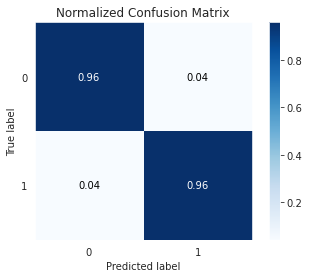

In [27]:
# Plotting Logistic Regression model - Test dataset

# Plotting the confusion matrix

skplt.metrics.plot_confusion_matrix(y_test, y_pred_t1, normalize=True)

# Print classification report

print("classification report: \n", classification_report(y_test, y_pred_t1, digits=4))

# Print model accuracy

print("Accuracy: {}".format(accuracy_score(y_test, y_pred_t1)))

# Print area under curve

print('AUC:{}'.format(roc_auc_score(y_test, y_pred_t1)))

## Conclusion

That could be considered a easy data science project however, as could be seen, it was not trivial to obtain the results. The trained model worked quite well on the test data set but there is certainly room for improvement. Testing other models or tuning the parameters are some things that could result in better predictions.